## Setup imports

In [1]:
import tensorflow as tf
import os
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.utils import shuffle
import random
from tensorflow.compiler.tf2xla.python import xla


2023-04-16 00:36:54.291650: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-16 00:36:54.441381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
rand_seed = 42
tf.random.set_seed(rand_seed)
weights_base_path = ""
images_base_path = ""

## Load the dataset and visualize the data

We use the `keras.datasets.mnist.load_data()` utility to directly pull the MNIST dataset
in the form of `NumPy` arrays. We then arrange it in the form of the train and test
splits.

Following loading the dataset, we select 4 random samples from within the training set
and visualize them using `matplotlib.pyplot`.

4 Random Training samples and labels


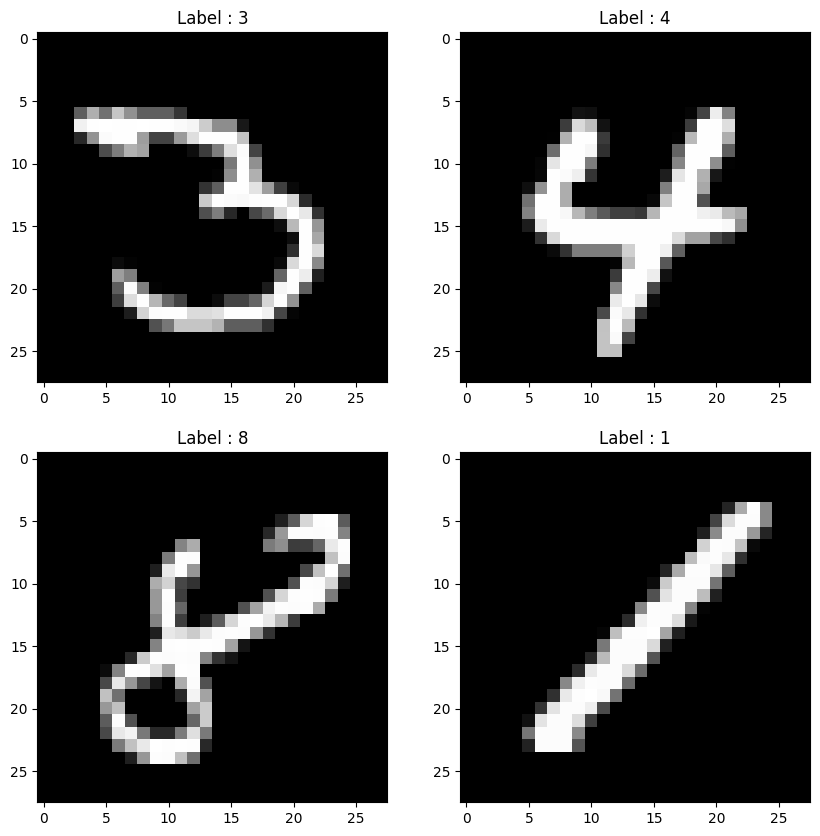

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train, y_train = shuffle(x_train, y_train, random_state=rand_seed)
x_test, y_test = shuffle(x_test, y_test, random_state=rand_seed)

print("4 Random Training samples and labels")
idx1, idx2, idx3, idx4 = random.sample(range(0, x_train.shape[0]), 4)

img1 = (x_train[idx1], y_train[idx1])
img2 = (x_train[idx2], y_train[idx2])
img3 = (x_train[idx3], y_train[idx3])
img4 = (x_train[idx4], y_train[idx4])

imgs = [img1, img2, img3, img4]

plt.figure(figsize=(10, 10))

for idx, item in enumerate(imgs):
    image, label = item[0], item[1]
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label : {label}")
plt.show()

class_names = np.asarray([str(i) for i in range(10)])

true_labels = class_names[y_test]


## Performance metrics and visualization

In [4]:
def plot_loss_curve(history, title, path_to_save=None):
    plt.plot(history.history["FinalLoss"], label="Training loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    if path_to_save:
        plt.savefig(path_to_save)


def load_eval_best_model(model, weights_path, test_images, true_labels, class_names, model_name):
    model.load_weights(weights_path)
    preds = model.predict(tf.convert_to_tensor(test_images))
    preds = preds.reshape((preds.shape[0], preds.shape[1]))
    pred_labels = class_names[np.argmax(preds, axis=1)]
   
    cm = confusion_matrix(true_labels, preds)

    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)

    disp.plot(ax=ax, xticks_rotation='vertical', colorbar=False)
    plt.title("Confusion matrix of the " +
              model_name + " model on MNIST test set")
    plt.show()

    acc = accuracy_score(true_labels, preds)
    print(f"Test error rate: {1 - acc:.4f}")
    print(classification_report(true_labels, preds))


## Define `FFDense` custom layer


In [5]:

class FFDense(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Dense layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        units,
        optimizer,
        loss_metric,
        num_epochs=50,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs


    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.dense(x_dir)
        return self.relu(res)


    def forward_forward(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                g_pos = tf.math.reduce_mean(tf.math.pow(self.call(x_pos), 2), 1)
                g_neg = tf.math.reduce_mean(tf.math.pow(self.call(x_neg), 2), 1)

                loss = tf.math.log(
                    1
                    + tf.math.exp(
                        tf.concat([-g_pos + self.threshold, g_neg - self.threshold], 0)
                    )
                )
                mean_loss = tf.cast(tf.math.reduce_mean(loss), tf.float32)
                self.loss_metric.update_state([mean_loss])
            gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
        return (
            tf.stop_gradient(self.call(x_pos)),
            tf.stop_gradient(self.call(x_neg)),
            self.loss_metric.result(),
        )


## Define the `FFNetwork` Custom Model

In [6]:

class FFNetwork(keras.Model):
    """
    A `keras.Model` that supports a `FFDense` network creation. This model
    can work for any kind of classification task. It has an internal
    implementation with some details specific to the MNIST dataset which can be
    changed as per the use-case.
    """

    def __init__(
        self,
        dims,
        layer_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.03),
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.layer_optimizer = layer_optimizer
        self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.layer_list = [keras.Input(shape=(dims[0],))]
        for d in range(len(dims) - 1):
            self.layer_list += [
                FFDense(
                    dims[d + 1],
                    optimizer=self.layer_optimizer,
                    loss_metric=keras.metrics.Mean(),
                )
            ]

    @tf.function(reduce_retracing=True)
    def overlay_y_on_x(self, data):
        X_sample, y_sample = data
        max_sample = tf.reduce_max(X_sample, axis=0, keepdims=True)
        max_sample = tf.cast(max_sample, dtype=tf.float64)
        X_zeros = tf.zeros([10], dtype=tf.float64)
        X_update = xla.dynamic_update_slice(X_zeros, max_sample, [y_sample])
        X_sample = xla.dynamic_update_slice(X_sample, X_update, [0])
        return X_sample, y_sample

    @tf.function(reduce_retracing=True)
    def predict_one_sample(self, x):
        goodness_per_label = []
        x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1]])
        for label in range(10):
            h, label = self.overlay_y_on_x(data=(x, label))
            h = tf.reshape(h, [-1, tf.shape(h)[0]])
            goodness = []
            for layer_idx in range(1, len(self.layer_list)):
                layer = self.layer_list[layer_idx]
                h = layer(h)
                goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)]
            goodness_per_label += [
                tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1)
            ]
        goodness_per_label = tf.concat(goodness_per_label, 1)
        return tf.cast(tf.argmax(goodness_per_label, 1), tf.float64)

    def predict(self, data):
        x = data
        preds = list()
        preds = tf.map_fn(fn=self.predict_one_sample, elems=x)
        return np.asarray(preds, dtype=int)

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Flatten op
        x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2]])

        x_pos, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, y))

        random_y = tf.random.shuffle(y)
        x_neg, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, random_y))

        h_pos, h_neg = x_pos, x_neg

        for idx, layer in enumerate(self.layers):
            if isinstance(layer, FFDense):
                print(f"Training layer {idx+1} now : ")
                h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            else:
                print(f"Passing layer {idx+1} now : ")
                x = layer(x)
        mean_res = tf.math.divide(self.loss_var, self.loss_count)
        return {"FinalLoss": mean_res}


## Convert MNIST `NumPy` arrays to `tf.data.Dataset`

We now perform some preliminary processing on the `NumPy` arrays and then convert them
into the `tf.data.Dataset` format which allows for optimized loading.

In [7]:
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

## Fit the network and visualize results

Having performed all previous set-up, we are now going to run `model.fit()` and run 250
model epochs, which will perform 50*250 epochs on each layer. We get to see the plotted loss
curve as each layer is trained.

In [8]:
model = FFNetwork(dims=[784, 800, 800])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=[keras.metrics.Mean()],
)

epochs = 250
history = model.fit(train_dataset, epochs=epochs)

Epoch 1/250


2023-04-16 00:37:00.235213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [60000]
	 [[{{node Placeholder/_1}}]]


Training layer 1 now : 
Training layer 2 now : 
Training layer 1 now : 
Training layer 2 now : 


2023-04-16 00:37:18.117691: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7ff26c00ba40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-16 00:37:18.117737: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2023-04-16 00:37:19.308387: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-16 00:38:25.787533: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 193s 193s/step - FinalLoss: 0.7307
Epoch 2/250
1/1 [==============================] - 102s 102s/step - FinalLoss: 0.7116
Epoch 3/250
1/1 [==============================] - 96s 96s/step - FinalLoss: 0.6983
Epoch 4/250
1/1 [==============================] - 96s 96s/step - FinalLoss: 0.6772
Epoch 5/250
1/1 [==============================] - 96s 96s/step - FinalLoss: 0.6547
Epoch 6/250
1/1 [==============================] - 97s 97s/step - FinalLoss: 0.6338
Epoch 7/250
1/1 [==============================] - 95s 95s/step - FinalLoss: 0.6151
Epoch 8/250
1/1 [==============================] - 92s 92s/step - FinalLoss: 0.5981
Epoch 9/250
1/1 [==============================] - 84s 84s/step - FinalLoss: 0.5831
Epoch 10/250
1/1 [==============================] - 92s 92s/step - FinalLoss: 0.5696
Epoch 11/250
1/1 [==============================] - 94s 94s/step - FinalLoss: 0.5576
Epoch 12/250
1/1 [==============================] - 88s 88s/step - FinalLoss: 0.54

In [9]:
# save the weights of the model
weights_path = os.path.join(weights_base_path, "exp9")
model.save_weights(weights_path)

## Perform inference and testing

Having trained the model to a large extent, we now see how it performs on the
test set. We calculate the Accuracy Score to understand the results closely.

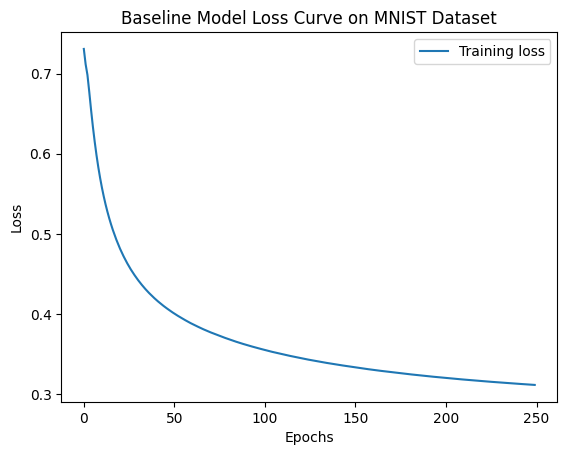

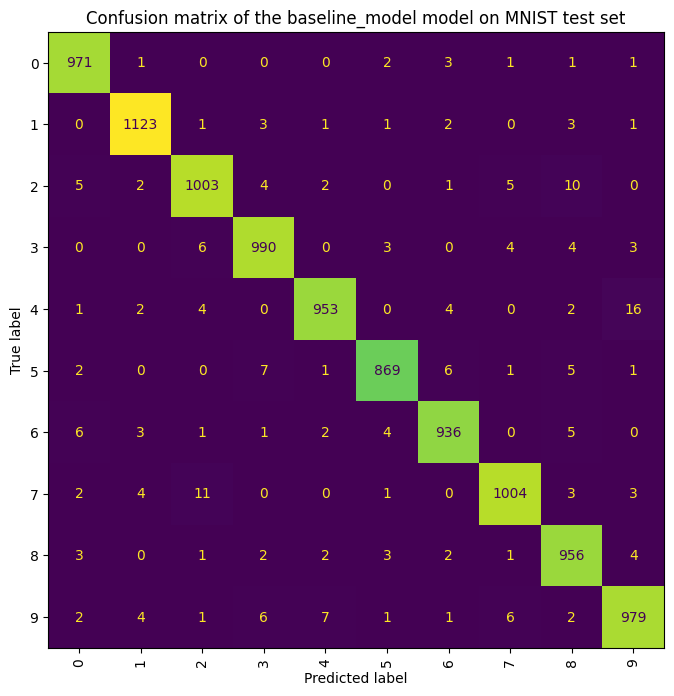

Test error rate: 0.0216
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.96      0.98      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [10]:

plot_path = os.path.join(images_base_path, "baseline-mnist.png")
plot_loss_curve(history,title="Baseline Model Loss Curve on MNIST Dataset")

model_name = "baseline_model"
load_eval_best_model(model, weights_path, x_test, y_test,class_names, model_name)
